https://iter01.com/575688.html
https://kknews.cc/zh-tw/code/k2geb4r.html


In [32]:
import pandas as pd
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# target_ToolGID = 'PK_DUVKrF'
target_ToolGID = 'XE_Sorter'
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

df_train=readDataFromFile('../../homework/training_data_20210302.csv')
df_train = df_train.loc[df_train['TOOLG_ID']==target_ToolGID]
# 觀察缺失值------------------------------------------
print(df_train.isnull().sum())
# 做数据切分------------------------------------------
print(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1).describe())
df_train_eh =df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1) 
X_dropped = np.asarray(df_train_eh)
Y_dropped = np.asarray(df_train['MOVE_QTY'])

X_train, X_val, y_train, y_val = train_test_split(X_dropped, Y_dropped,test_size =0.2, random_state=1)
xgTrain = xgb.DMatrix(X_train,y_train)
xgVal = xgb.DMatrix(X_val,y_val)

#調超參 best_nround-----------------------------------------------------------
 
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
num_round = 10
best_nround = 1000

# bst = xgb.train(param, dtrain, num_round)
# 设定watchlist用于查看模型状态
watchlist  =[(xgTrain, 'train'), (xgVal, 'valid')]

res = xgb.cv(other_params,xgTrain, nfold=3,num_boost_round=500,metrics='rmse',early_stopping_rounds=25)
# #找到最佳迭代轮数
best_nround = res.shape[0] - 1
print('找到最佳迭代轮数',best_nround)
bst = xgb.train(other_params, xgTrain, best_nround, watchlist)



MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              1
U              1
PT             0
UP_TIME        1
EQP_UTIL       1
TC             0
CS             0
AI             0
C_AI           0
dtype: int64
           WIP_QTY  NO_HOLD_QTY          M           U          PT  \
count   401.000000   401.000000  400.00000  400.000000  401.000000   
mean   2298.670823  1270.147132   16.79250    0.815054  262.588917   
std     609.330950   595.039625    1.01835    0.101562   16.646263   
min    1058.000000   431.000000   15.00000    0.055358  225.525207   
25%    1884.000000   870.000000   16.00000    0.804221  249.536313   
50%    2225.000000  1158.000000   17.00000    0.823748  267.549756   
75%    2592.000000  1550.000000   17.00000    0.850040  275.244853   
max    6795.000000  6099.000000   18.00000    0.940454  298.657525   

          UP_TIME    EQP_UTIL          TC          CS        C_AI  
count  400.000000  400.000000  401.000000  401.000

In [24]:
df_train

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
243,20200122,XE_Sorter,2570.0,1808.0,33413.0,15.0,0.863297,237.802561,0.971326,0.668134,0.487792,0.529806,1409.500000,0.378062
574,20200123,XE_Sorter,3630.0,2707.0,36440.0,15.0,0.850381,246.393321,0.990389,0.670181,0.468130,0.521642,1535.833333,0.265620
607,20200124,XE_Sorter,2913.0,2016.0,34169.0,15.0,0.890564,238.328042,0.995261,0.667693,0.462037,0.492073,1388.625000,0.239856
1078,20200125,XE_Sorter,2660.0,1709.0,36326.0,15.0,0.870101,237.719429,0.982166,0.656306,0.478864,0.507971,1517.541667,0.271172
1430,20200126,XE_Sorter,1935.0,994.0,33639.0,15.0,0.847407,247.964310,0.983204,0.666610,0.511254,0.542569,1367.291667,0.322381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118756,20210221,XE_Sorter,2613.0,1398.0,34810.0,16.0,0.880261,238.788866,0.999147,0.664293,0.412453,0.421615,1463.583333,0.192957
118868,20210222,XE_Sorter,3072.0,1934.0,32839.0,16.0,0.850081,238.672870,0.994506,0.670522,0.432766,0.442644,1373.333333,0.248371
119324,20210223,XE_Sorter,2283.0,1043.0,33494.0,16.0,0.856623,236.441398,0.995611,0.659633,0.459128,0.484667,1365.750000,0.318864
119677,20210224,XE_Sorter,2534.0,1098.0,32530.0,16.0,0.877079,229.847841,0.997594,0.658534,0.474278,0.491863,1345.666667,0.269017


In [25]:
import datetime

df_train[df_train['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))>pd.to_datetime('2020-11-01')]

df_train_filter28days =df_train[
    df_train['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))>
    
     df_train['MFG_DATE'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d')).max()- datetime.timedelta(days=28) ]
df_train_filter28days.to_csv('./df_train_filter28days.csv')  


In [26]:
df_testing = df_train_filter28days.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)

 

In [27]:
# df_train_filter28days = readDataFromFile('./df_train_filter28days.csv')
# df_train_filter28days

In [28]:

cols=['M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
#df_testing = df_train_filter28days.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)



df_testing = df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)
df_testing[cols]= df_testing[cols].mean()
# for col in df_testing.columns:
#     if col =='UP_TIME':
#         df_testing[col] = df_testing[df_testing['UP_TIME'].apply(lambda x: x>=0.96)]['UP_TIME'].mean() 
#     elif col =='M':
#         df_testing[col] = df_testing[df_testing[col].apply(lambda x: x>=31)][col].mean() 
#     elif col =='U':
#         df_testing[col] = df_testing[df_testing[col].apply(lambda x:  0.06 <=  x <=0.08)][col].mean()         
#     else:
#         df_testing[col]= df_testing[col].mean()
df_testing =df_testing[0:1]
print(df_testing.head())
# max_wip = df_testing['NO_HOLD_QTY'].max()* .75
max_wip = np.percentile(df_testing['NO_HOLD_QTY'], 50) # return 50th percentile, e.g median.
tick = (df_testing['NO_HOLD_QTY'].max() - df_testing['NO_HOLD_QTY'].min()) /400
if max_wip <=0 :
    max_wip=100
if tick <1 :
    tick = 1
print(max_wip,tick)

df = pd.DataFrame(columns = df_testing.columns)

for i in range(3000):
    df_testing['NO_HOLD_QTY']=max_wip+ tick*i
    df = df.append(df_testing,ignore_index=True)
# print(df.head())        


     WIP_QTY  NO_HOLD_QTY        M         U          PT   UP_TIME  EQP_UTIL  \
243   2570.0       1808.0  16.7925  0.815054  262.588917  0.977081  0.638293   

           TC        CS      C_AI  
243  0.506885  0.521573  0.298731  
1808.0 2


In [29]:
tick

2

In [30]:
df

,WIP_QTY,NO_HOLD_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI
0,2570.0,1808.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
1,2570.0,1810.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
2,2570.0,1812.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
3,2570.0,1814.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
4,2570.0,1816.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
...,...,...,...,...,...,...,...,...,...,...
2995,2570.0,7798.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
2996,2570.0,7800.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
2997,2570.0,7802.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731
2998,2570.0,7804.0,16.7925,0.815054,262.588917,0.977081,0.638293,0.506885,0.521573,0.298731


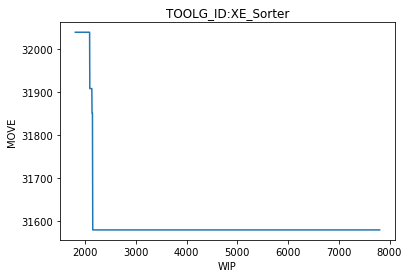

In [31]:
X_droppedtest = np.asarray(df)
xgtest = xgb.DMatrix(X_droppedtest)
y_predict = bst.predict(xgtest)
df['predict'] = y_predict

plt.plot(df['NO_HOLD_QTY'] , y_predict)
plt.title('TOOLG_ID:'+ df_train['TOOLG_ID'].iloc[0])
plt.xlabel("WIP")
plt.ylabel("MOVE")
 
plt.savefig('./'+df_train['TOOLG_ID'].iloc[0]+'2.pdf',width=600, height=350)#儲存檔案
plt.show()